# Dynap-SE

Dynap-SE board consists of 4 chips, each having 4 cores inside. Each core harbors 64 Adaptive Exponential Integrate-and-Fire (AdExpIF) neurons, each with 64 fan-in. That means each AdExpIF neuron has a potential of 64 synapses to receive incoming connections of its presynaptic neurons. There are 4 types of synapses: AMPA, NMDA, GABA_A, and GABA_B.

Each core holds a `parameter group` to store the neuronal and synaptic parameters for its 64 neurons and their incoming synapses. The neurons in the same core share the same parameter values, including time constants, refractory periods, and weights. Therefore, different connection strengths between neurons can only be achieved by setting the same connection multiple times.

For spike input, 1024 spike generators, or virtual neurons, are available implemented on the FPGA. Each of the spike generators can be used as a Poisson spike generator or a normal FPGA spike generator. The overview of the architecture is summarized in figure below.

![architecture](images/dynapse.png)

The connectivity and information delivery between neurons a two-stage tag-based routing scheme [1] is used. It’s a novel routing methodology to handle the asynchronous address-event traffic. In this tutorial detailed explanation of the routing mechanism is omitted. The simulator can be used by defining a simple weight matrices.

<!-- ![network](./images/network_v2.png) -->

[1] S. Moradi, N. Qiao, F. Stefanini, and G. Indiveri, “A scalable multicore architecture with heterogeneous memory structures for dynamic neuromorphic asynchronous processors (dynaps),” IEEE Transactions on Biomedical Circuits and Systems, vol. 12, no. 1, pp. 106–122, 2018.

In [4]:
import sys
sys.path.append(
    "/home/ugurc/SynSense Dropbox/Ugurcan Cakal/repos/dynapse1/ctxctl_contrib"
)

import samna.dynapse1 as dyn1

from netgen import Neuron, NetworkGenerator
from rockpool.nn.modules import TimedModuleWrapper
from rockpool.nn.combinators import Sequential

from rockpool.devices.dynapse.config.simconfig import DynapSE1SimBoard

from rockpool.devices.dynapse.se1_jax import (
    DynapSE1Jax,
)

from rockpool.devices.dynapse.fpga_jax import (
    DynapSEFPGA,
)

from rockpool.devices.dynapse.utils.spike_input import (
    random_spike_train
)

from rockpool.devices.dynapse.infrastructure.router import (
    Router
)

from rockpool.devices.dynapse.utils.figure import (
    Figure
)

import numpy as np
import jax.numpy as jnp

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

## Configure the simulator

In [5]:
net_gen = NetworkGenerator()

spikegen_ids = [(0, 0, 50), (0, 0, 59), (0, 0, 78)]
spikegens = []
for spikegen_id in spikegen_ids:
    spikegens.append(Neuron(spikegen_id[0], spikegen_id[1], spikegen_id[2], True))

neuron_ids = [
    (1, 0, 20),
    (1, 0, 36),
    (1, 0, 60),
    (3, 0, 107),
    (3, 0, 152),
    (3, 0, 110),
]
neurons = []
for nid in neuron_ids:
    neurons.append(Neuron(nid[0], nid[1], nid[2]))
    

# connect neuron0 to other neurons
net_gen.add_connection(spikegens[0], neurons[0], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegens[0], neurons[1], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegens[0], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[0], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[1], neurons[3], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[1], neurons[4], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(spikegens[2], neurons[2], dyn1.Dynapse1SynType.GABA_A)


net_gen.add_connection(neurons[4], neurons[0], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(neurons[4], neurons[0], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(neurons[0], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[1], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[4], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[2], neurons[2], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[2], neurons[2], dyn1.Dynapse1SynType.NMDA)
net_gen.add_connection(neurons[0], neurons[4], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[4], neurons[3], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[4], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(neurons[3], neurons[5], dyn1.Dynapse1SynType.AMPA)

net_gen.network

Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C1c0n20: [('C0c0s50', 'AMPA'), ('C3c0n152', 'GABA_B'), ('C3c0n152', 'GABA_B')]
C1c0n36: [('C0c0s50', 'AMPA')]
C1c0n60: [('C0c0s50', 'NMDA'), ('C0c0s50', 'NMDA'), ('C0c0s78', 'GABA_A'), ('C1c0n20', 'AMPA'), ('C1c0n36', 'AMPA'), ('C3c0n152', 'AMPA'), ('C3c0n107', 'AMPA'), ('C1c0n60', 'AMPA'), ('C1c0n60', 'NMDA')]
C3c0n107: [('C0c0s59', 'NMDA'), ('C3c0n152', 'AMPA')]
C3c0n152: [('C0c0s59', 'NMDA'), ('C1c0n20', 'AMPA'), ('C3c0n107', 'AMPA')]
C3c0n110: [('C3c0n107', 'AMPA')]

In [6]:
config = net_gen.make_dynapse1_configuration()
# modSE = DynapSE1Jax.simulator_from_config(config)
CAM_in, idx_map_in = Router.CAM_in_from_config(config, return_maps=True)
CAM_rec, idx_map_rec = Router.CAM_rec_from_config(config, return_maps=True)

# CAM_shape: size_out, size_in // 4, 4
in_shape = CAM_in.shape  # size_in, size_out // 4, 4
rec_shape = CAM_rec.shape  # size_out, size_in // 4, 4

# 2D module shapes
fpga_shape = (in_shape[0], in_shape[1] * in_shape[2])
se1_shape = (rec_shape[2] * rec_shape[1], rec_shape[0])
has_rec = True
sim_config = DynapSE1SimBoard.from_idx_map(idx_map_rec)

w_in = sim_config.weight_matrix(CAM_in)
w_rec = sim_config.weight_matrix(CAM_rec)

# Obtain a TimedModuleWrapper and sequentially combine input layer with simulation layer
fpga = DynapSEFPGA(fpga_shape, sim_config, w_in, idx_map_in)
se1 = DynapSE1Jax(se1_shape, sim_config, has_rec, w_rec, idx_map_rec)
modSE = TimedModuleWrapper(
    Sequential(fpga, se1),
    dt=se1.dt,
        )
modSE

TimedModuleWrapper  with shape (3, 6) {
    JaxSequential '_module' with shape (3, 6) {
        DynapSEFPGA '0_DynapSEFPGA' with shape (3, 24)
        DynapSE1Jax '1_DynapSE1Jax' with shape (24, 6)
    }
} with JaxSequential '_module' as module

In [7]:
config = net_gen.make_dynapse1_configuration()
CAM_rec, idx_map = Router.CAM_rec_from_config(config, return_maps=True)
sim_config = DynapSE1SimBoard.from_idx_map(idx_map)

In [8]:
# CAM_in, idx_map = Router.CAM_in_from_config(config, return_maps=True)

# # CAM_shape: size_in, size_out // 4, 4
# CAM_shape = CAM_in.shape  # N_pre, N_post, 4(syn_type)
# mod_shape = (CAM_shape[0], CAM_shape[1] * CAM_shape[2])

# sim_config = DynapSE1SimBoard.from_idx_map(idx_map)

# w_in = sim_config.weight_matrix(CAM_in)
# mod = cls(mod_shape, w_in, idx_map)

In [9]:
# DynapSEFPGA(mod_shape, w_in, idx_map)

In [10]:
# DynapSEFPGA.from_config(config)

In [11]:
sim_config.Iw_base

{(1, 0): array([1.e-06, 2.e-06, 4.e-06, 8.e-06]),
 (3, 0): array([1.e-06, 2.e-06, 4.e-06, 8.e-06])}

In [12]:
fpga = modSE._module.__getattribute__('0_DynapSEFPGA')
se1 = modSE._module.__getattribute__('1_DynapSE1Jax')

## Input Spike Train

Generate an input spike train using utility functions provided `rockpool.devices.dynapse.utils.random_spike_train()` or `rockpool.devices.dynapse.utils.custom_spike_train()`

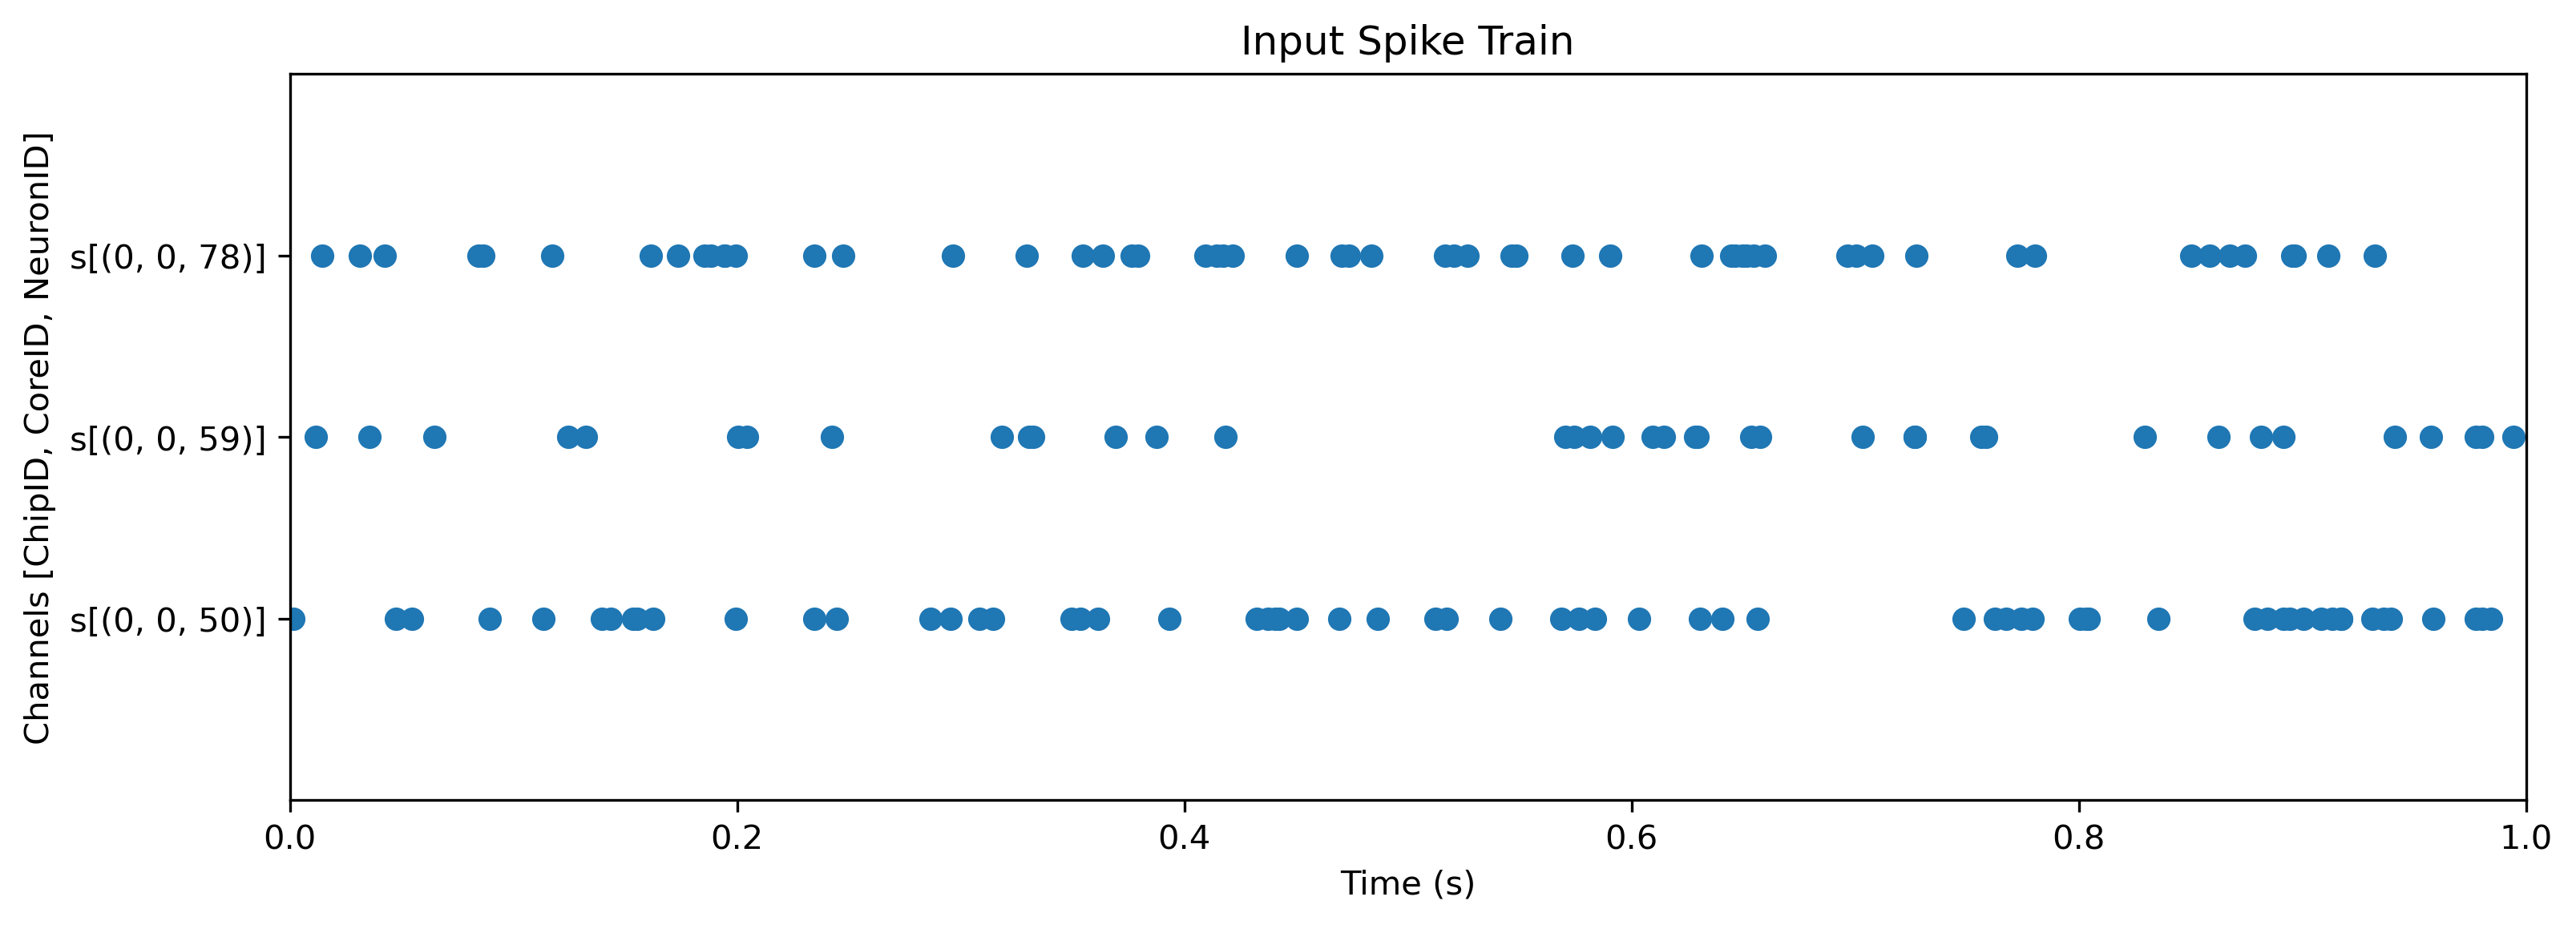

In [13]:
T = 1 # duration in seconds
rate = 50 # firing rate in Hertz

input_ts = random_spike_train(
    duration = T,
    n_channels=len(spikegens),
    rate=rate,
    dt=modSE.dt,
    name='Input Spike Train',
    channel_labels = spikegen_ids
)

input_ts.plot();

## Run the device simulator

Run the model to get output spikes, new_state and the record dictionary. Output spikes is the response of the system, new_state is the resulting state that the network got into, and the record dictionary stores the evolution of the currents. 

In [14]:
out_spikes, new_state, record_dict = modSE(input_ts, record=True)

# Visualize the State Change

In [15]:
rd = record_dict["1_DynapSE1Jax"]

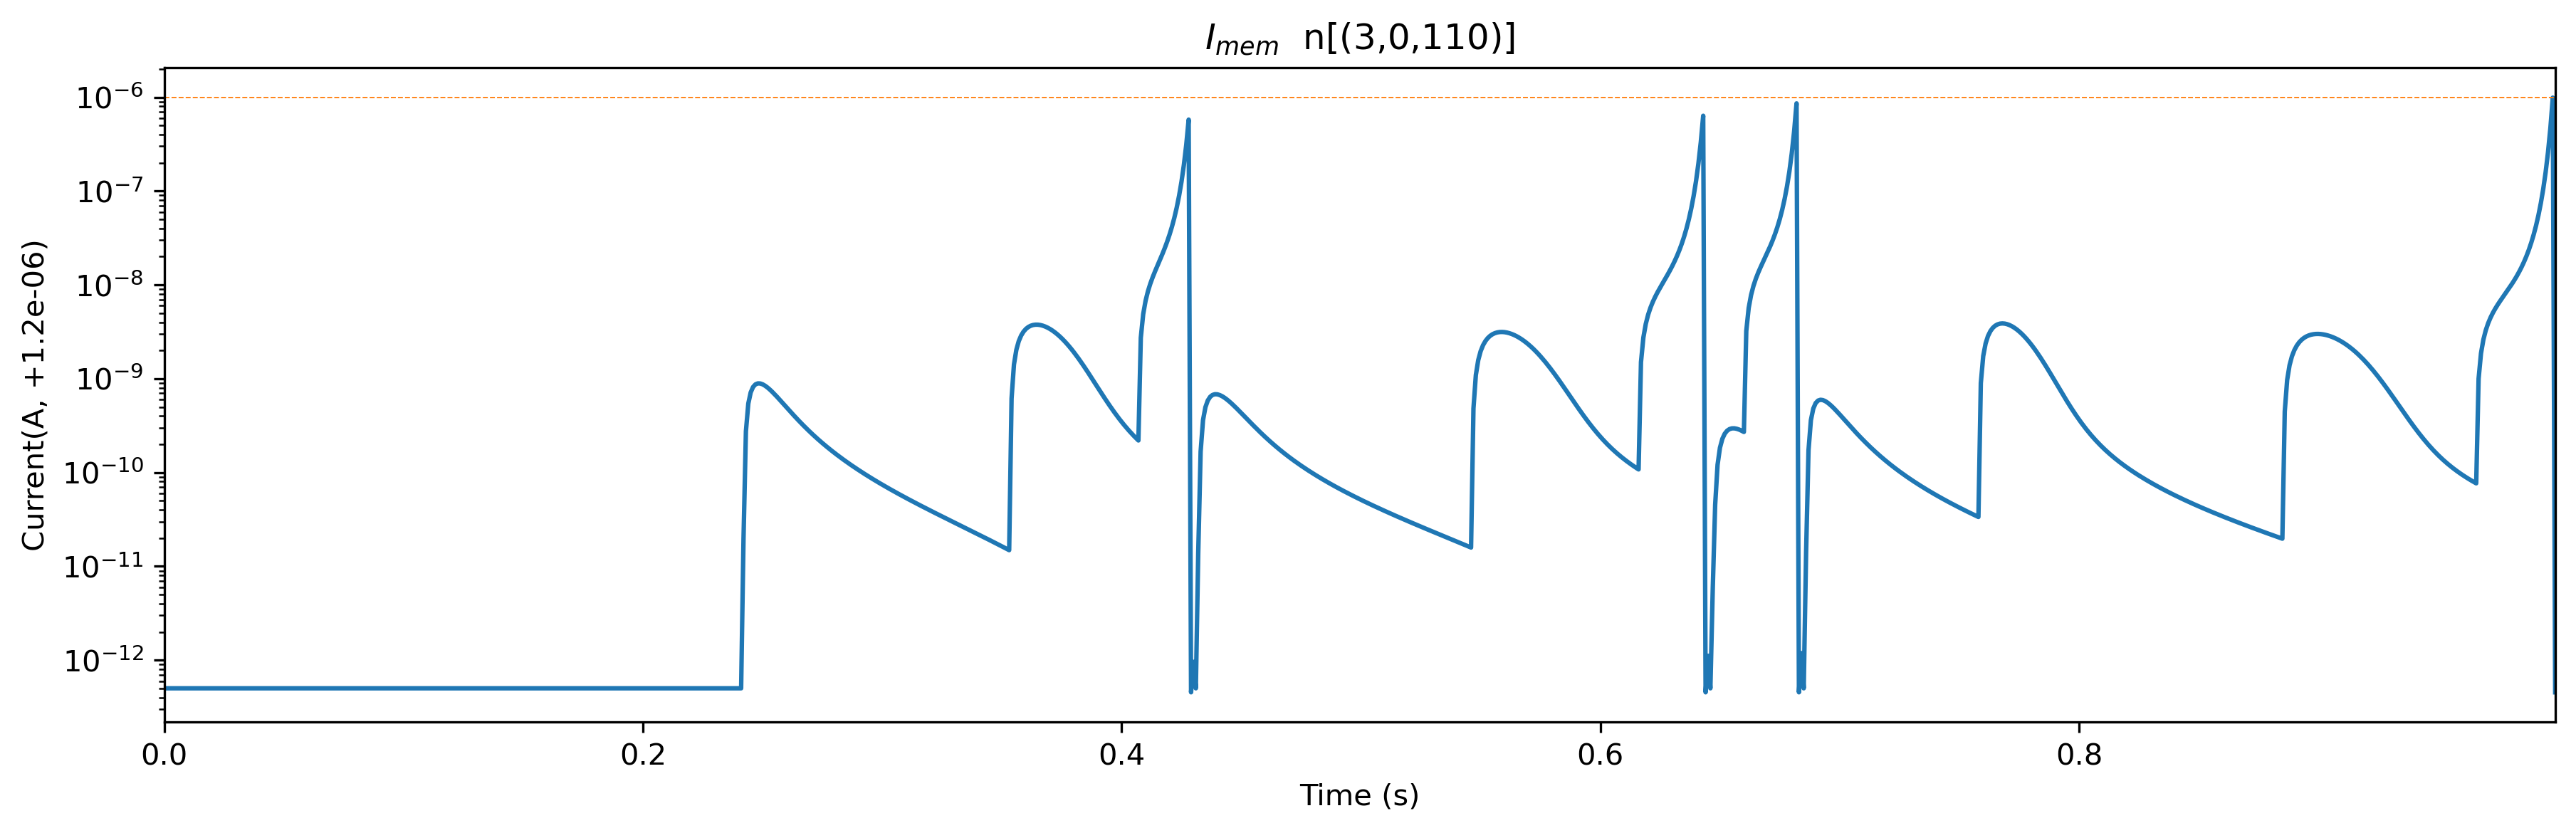

In [16]:
Figure.plot_Ix(rd["Imem"][:,4], se1.Ispkthr[4], name="$I_{mem}$  n[(3,0,110)]");
plt.yscale('log')

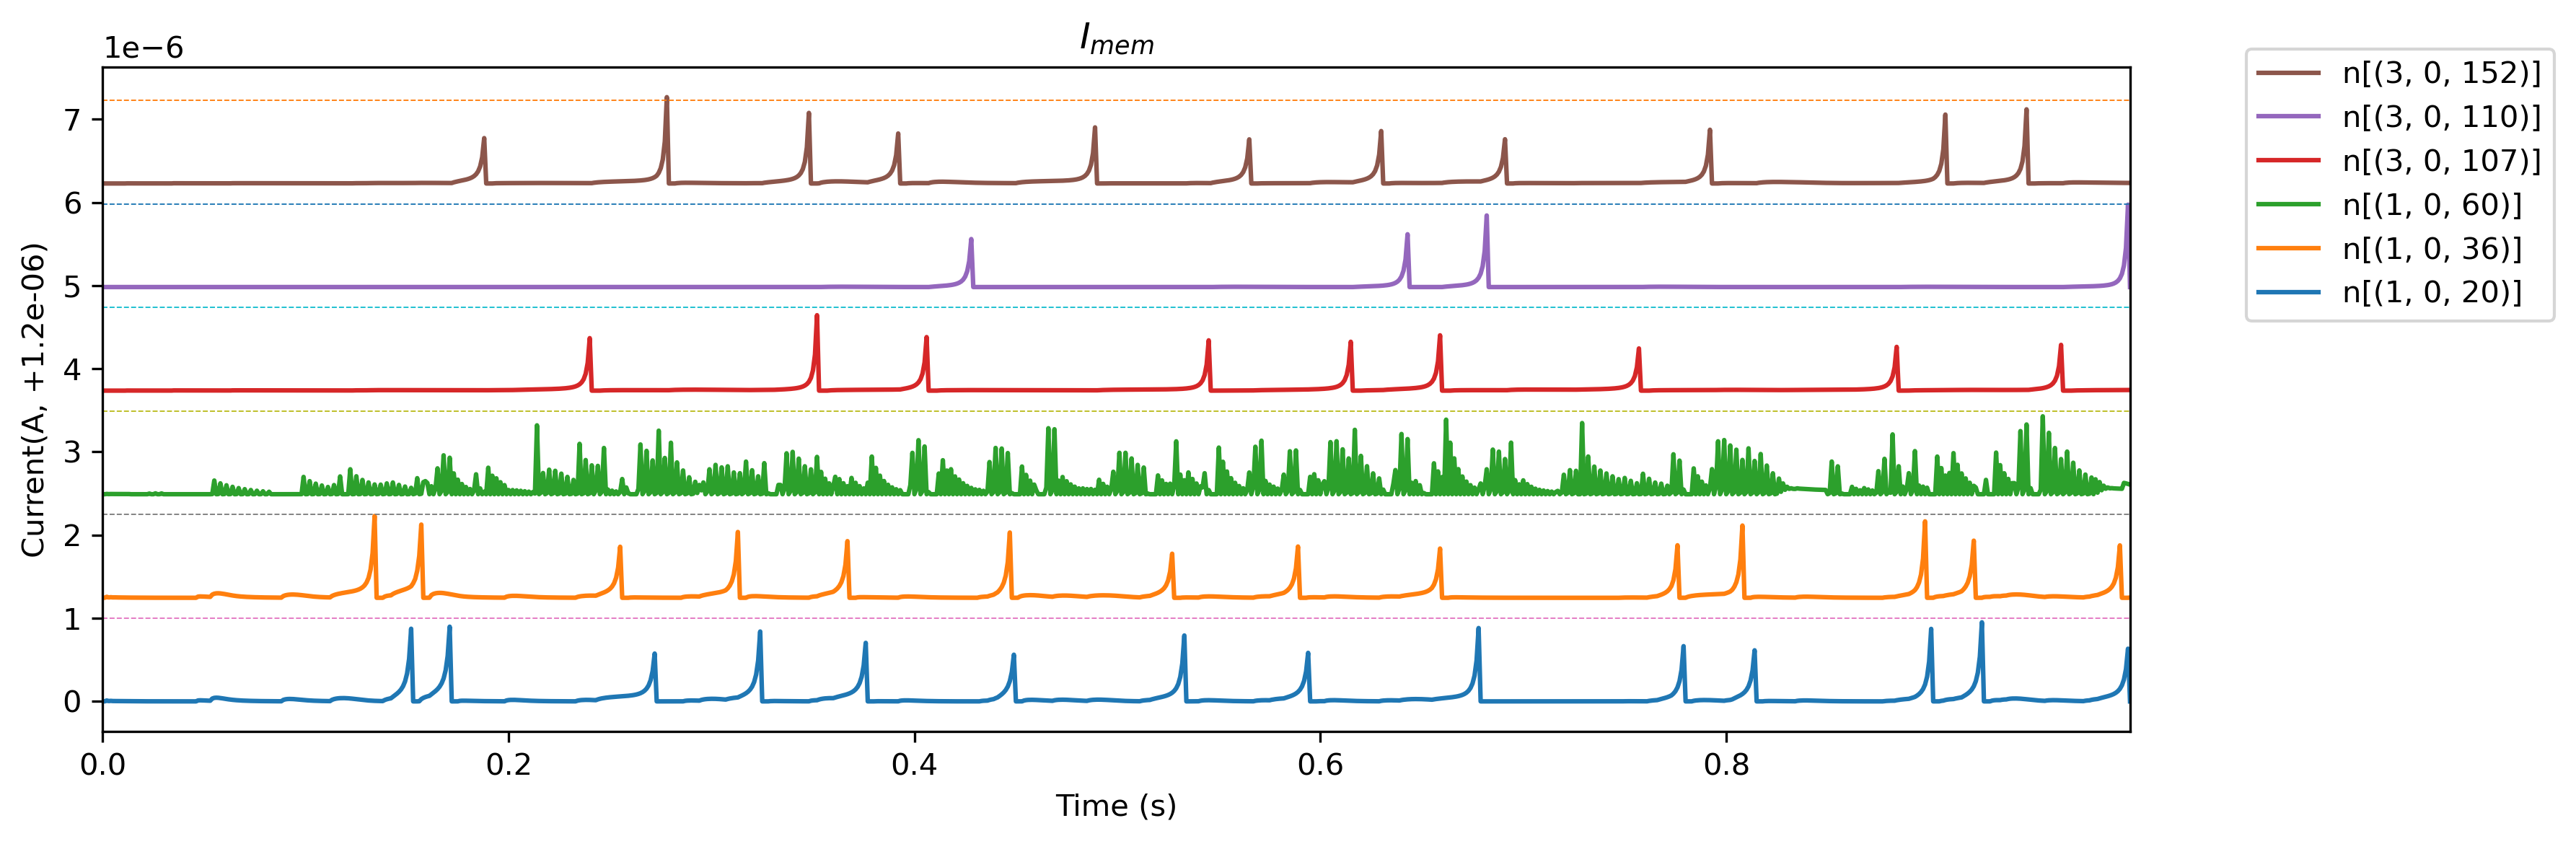

In [17]:
Figure.plot_Ix(rd["Imem"], se1.Ispkthr, name="$I_{mem}$", idx_map=se1.idx_map);

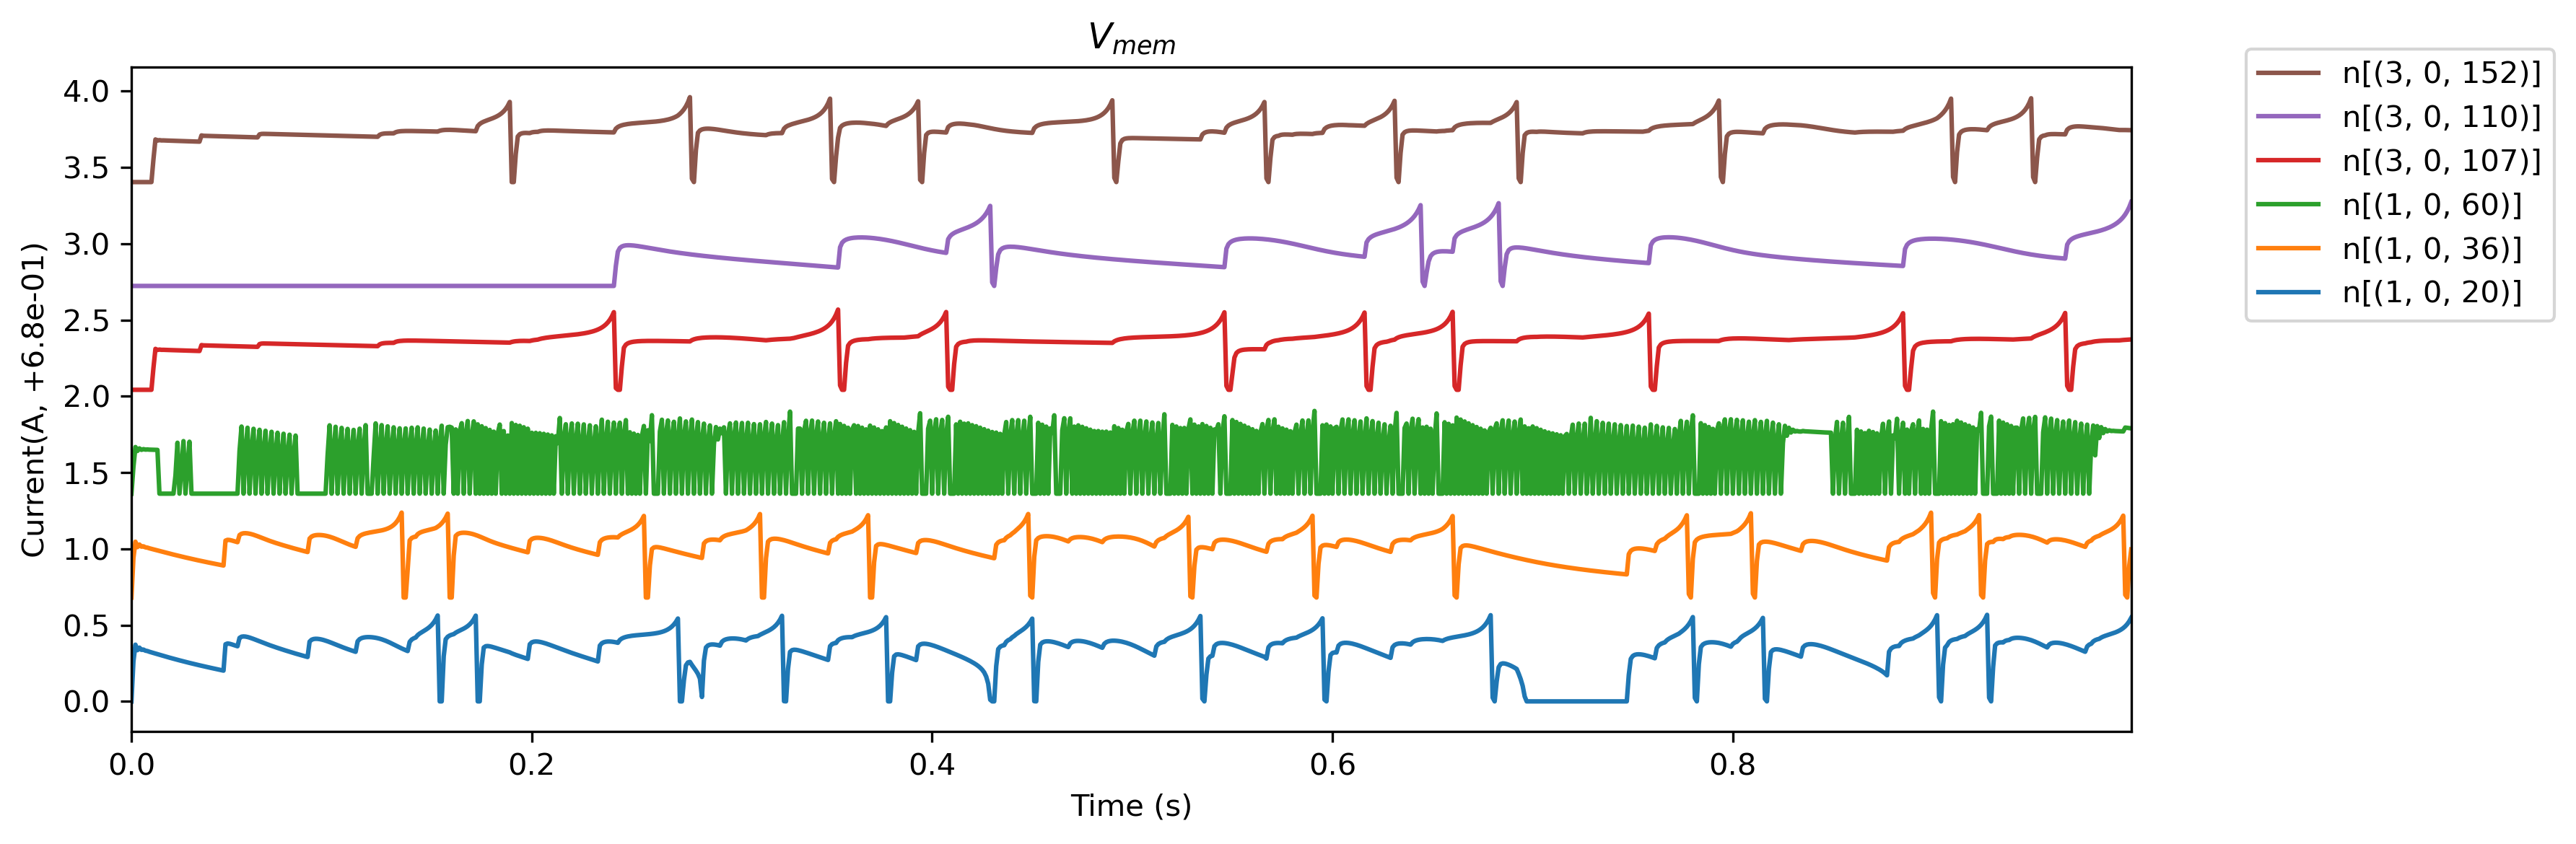

In [18]:
Figure.plot_Ix(rd["Vmem"], name="$V_{mem}$", idx_map=se1.idx_map);

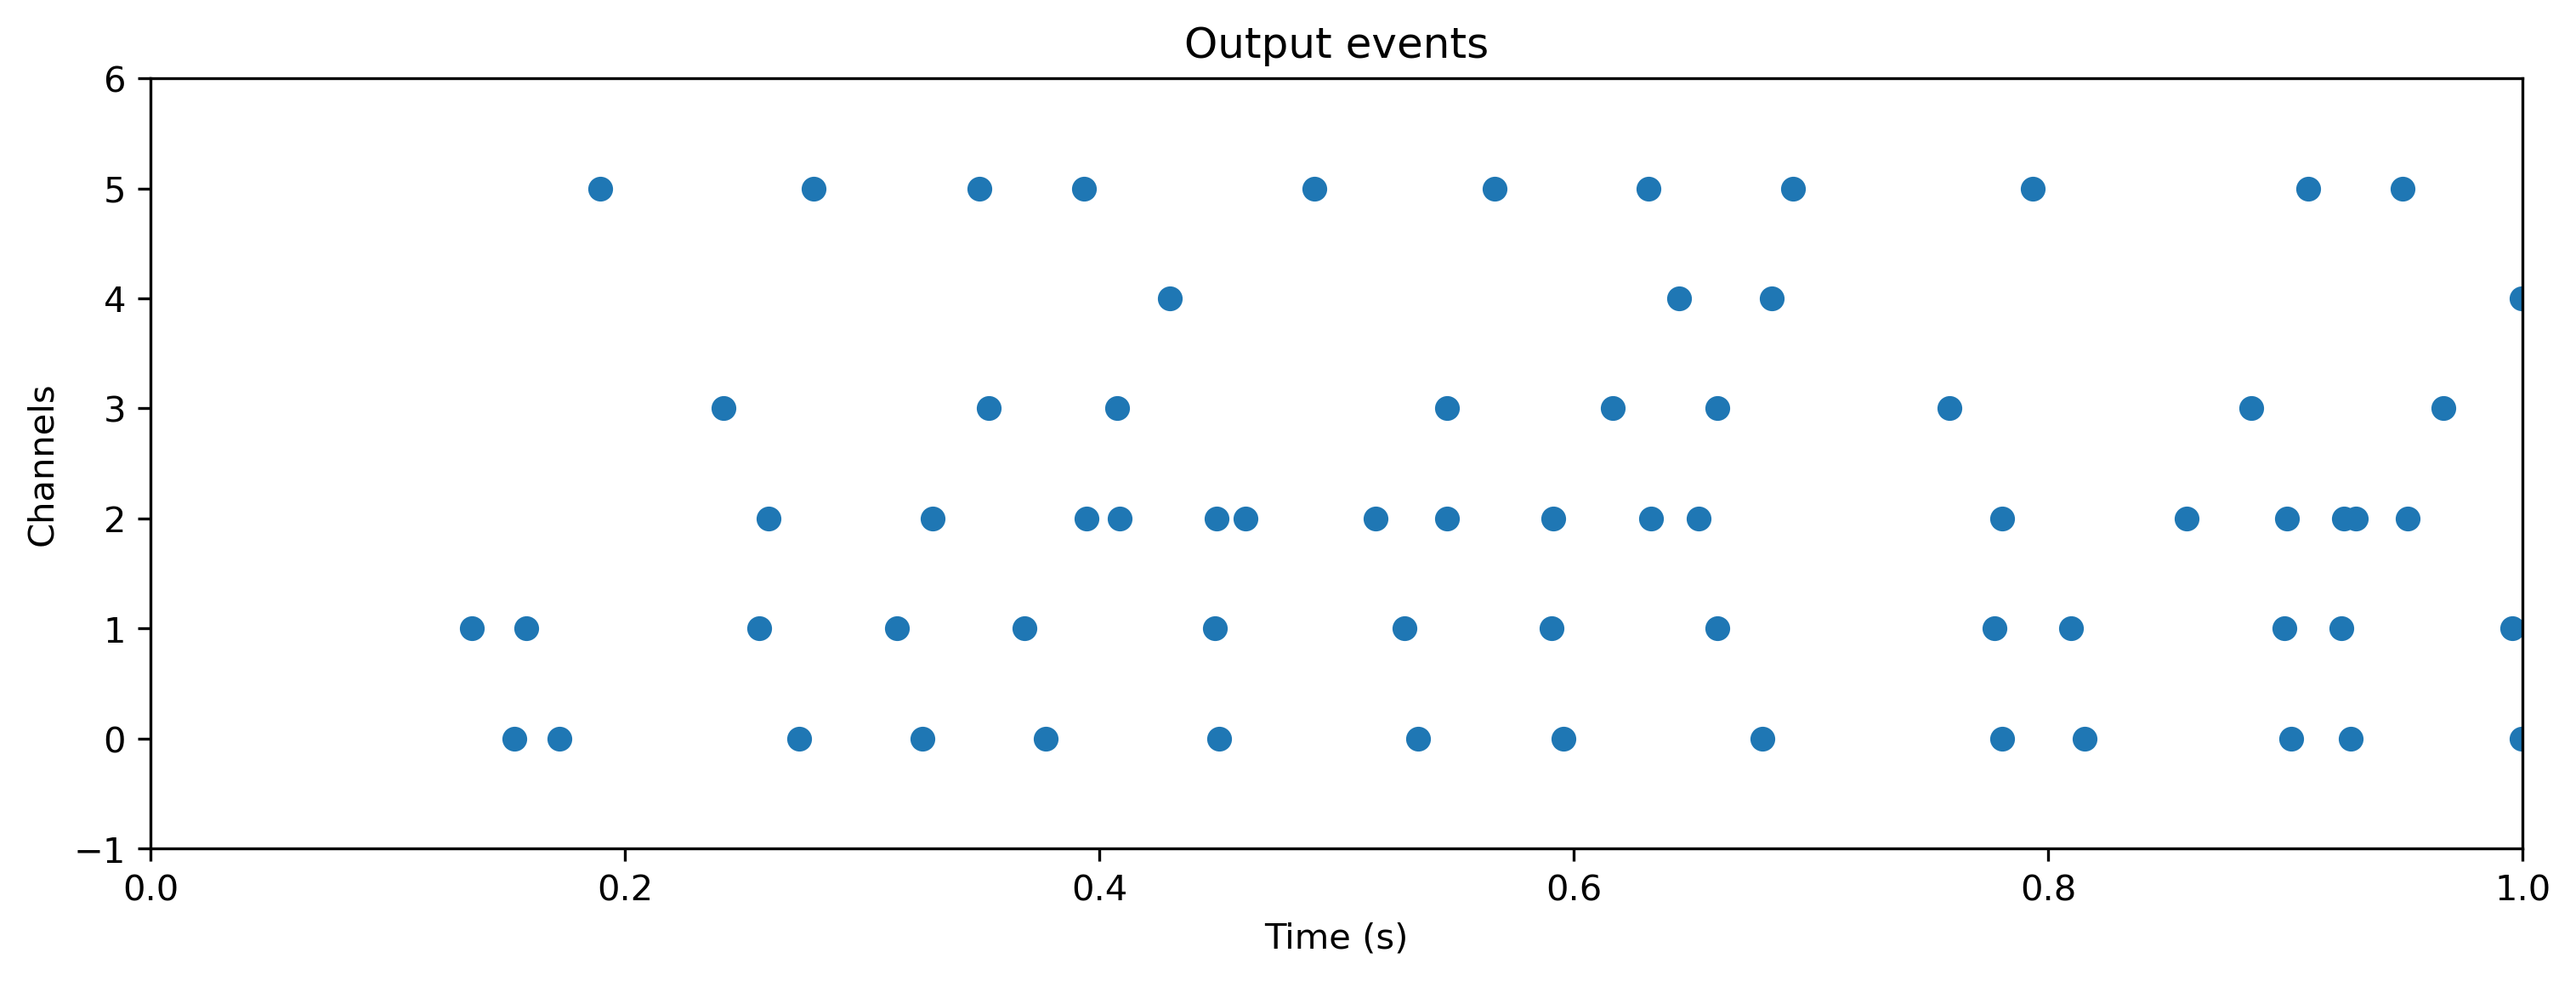

In [19]:
# Figure.plot_spikes(record_dict["1_DynapSE1Jax_output"], name="Output Spikes", idx_map=se1.idx_map);
out_spikes.plot()

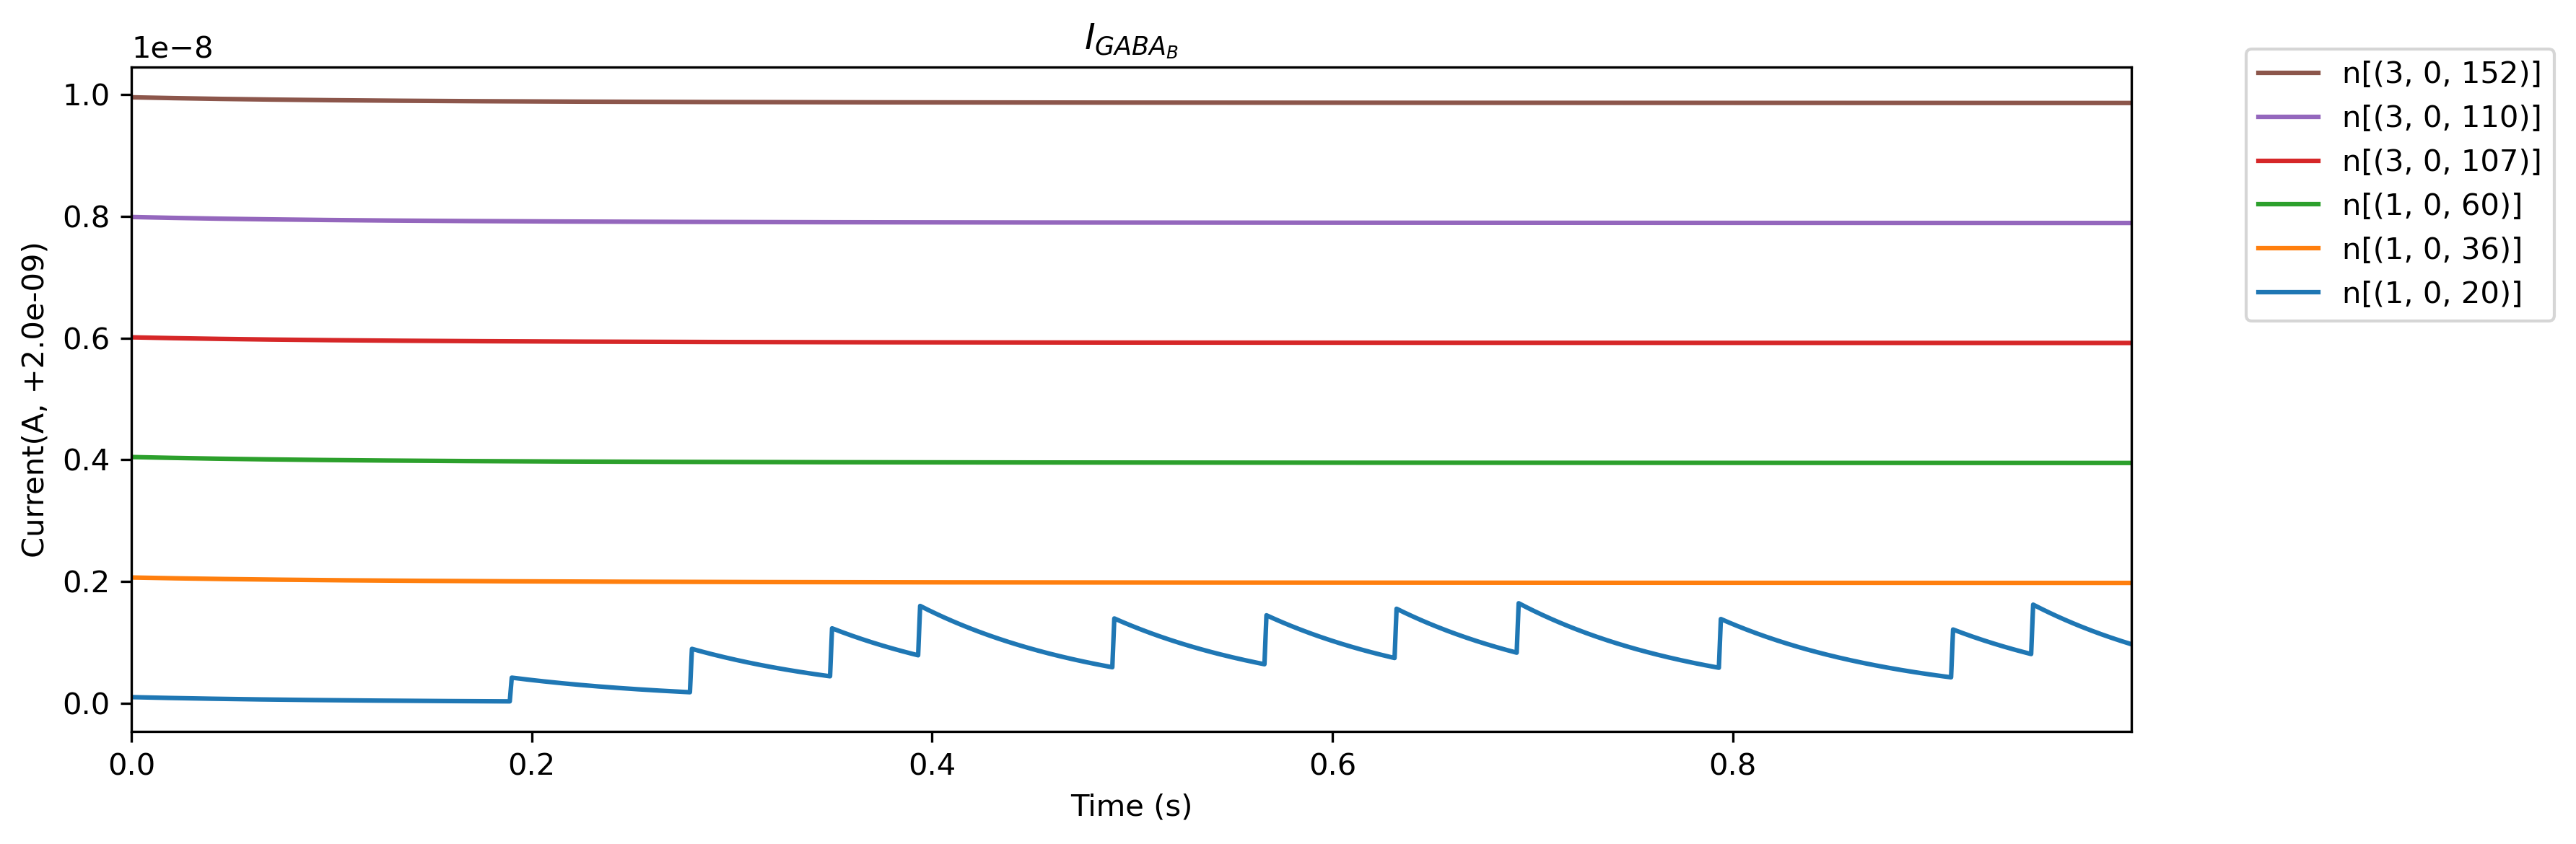

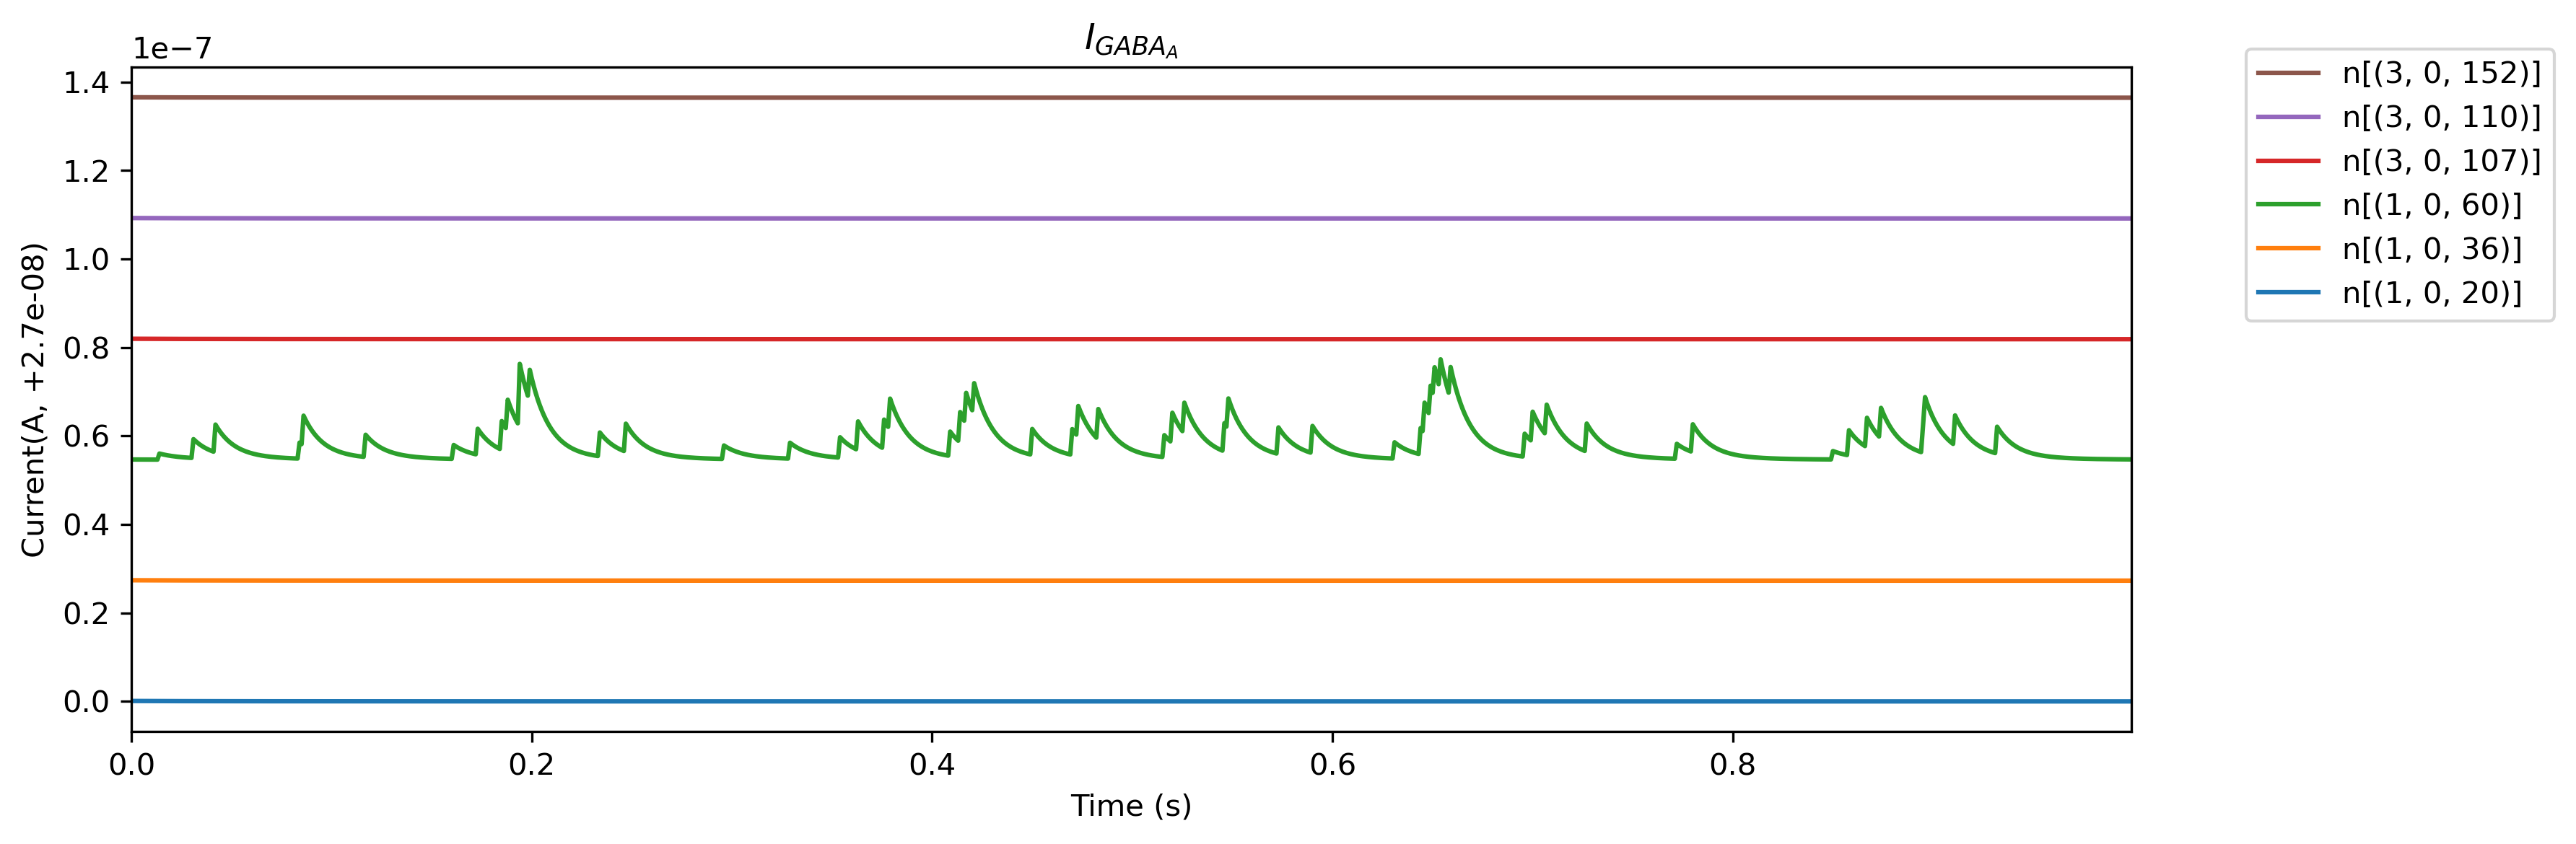

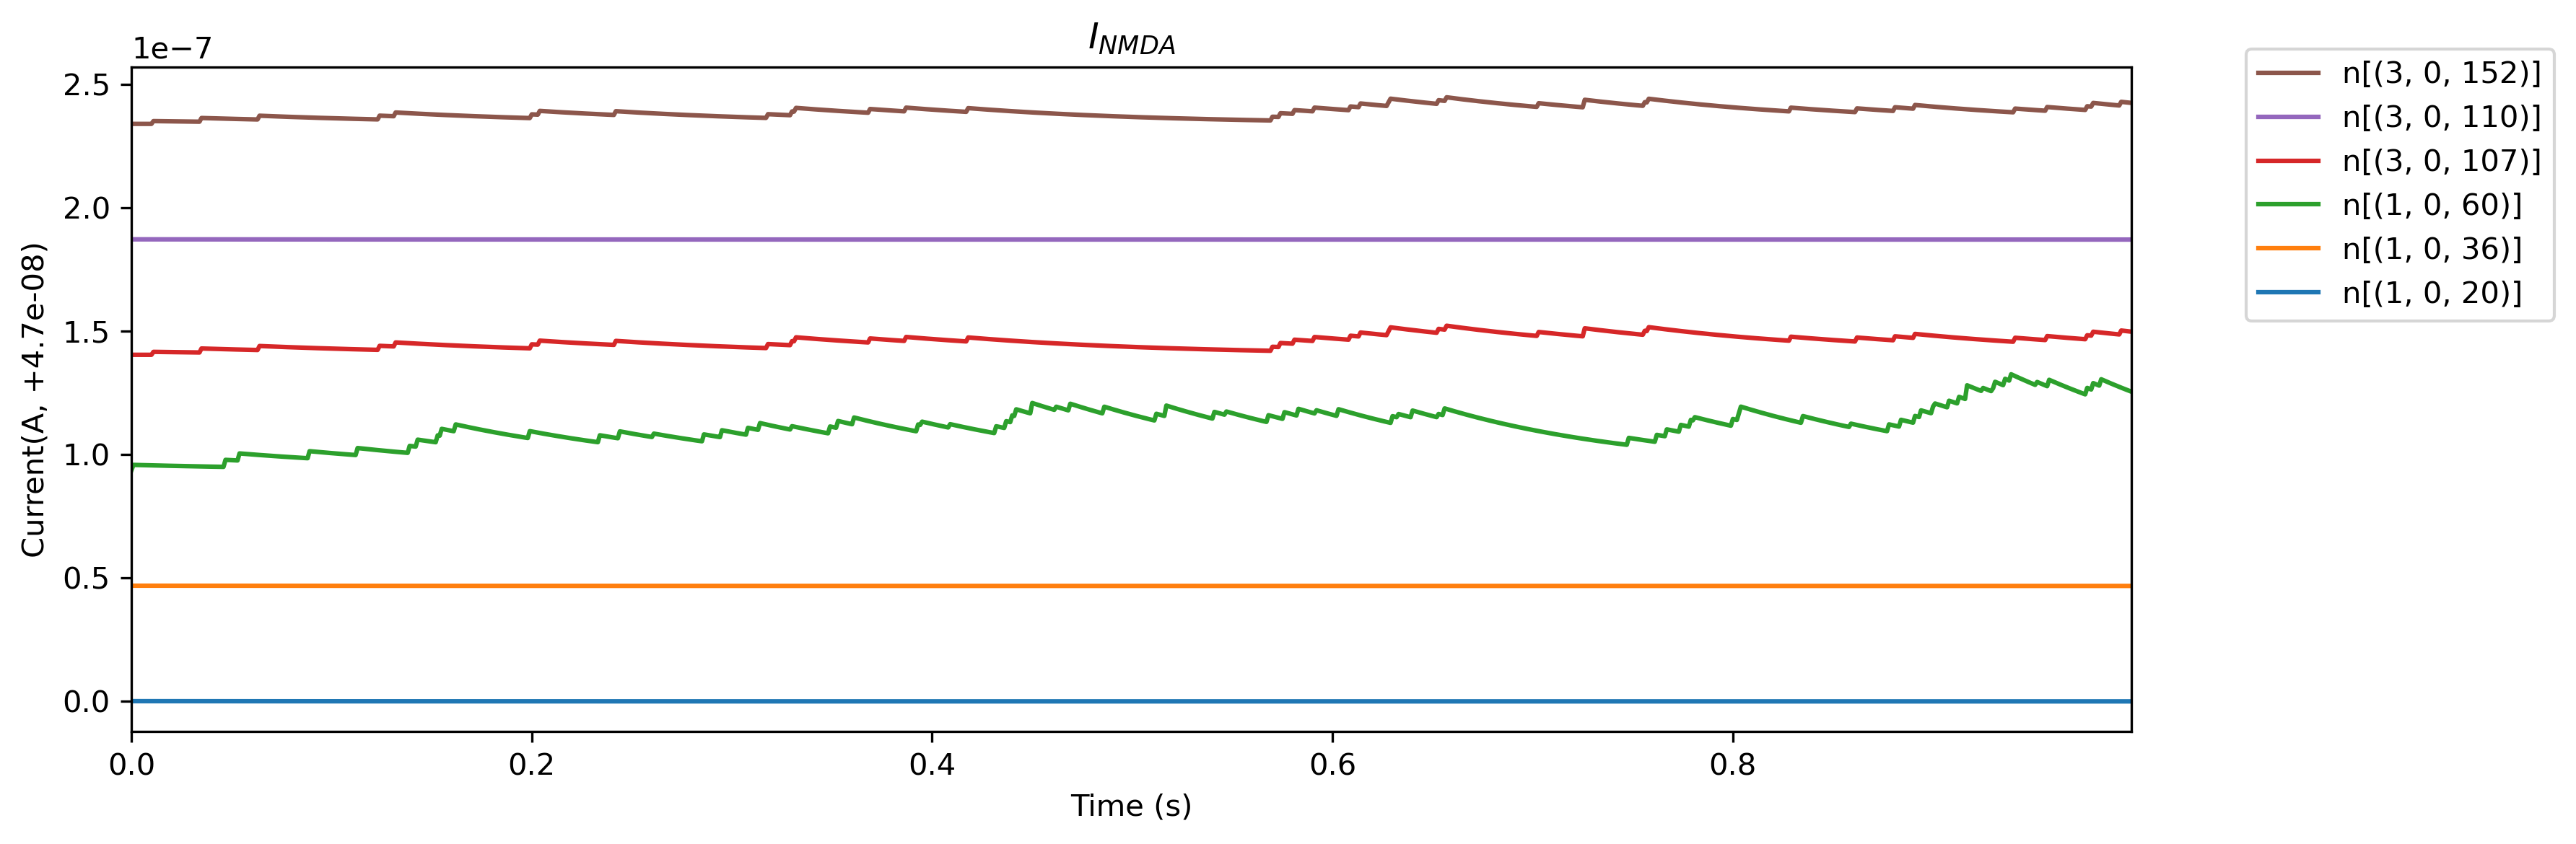

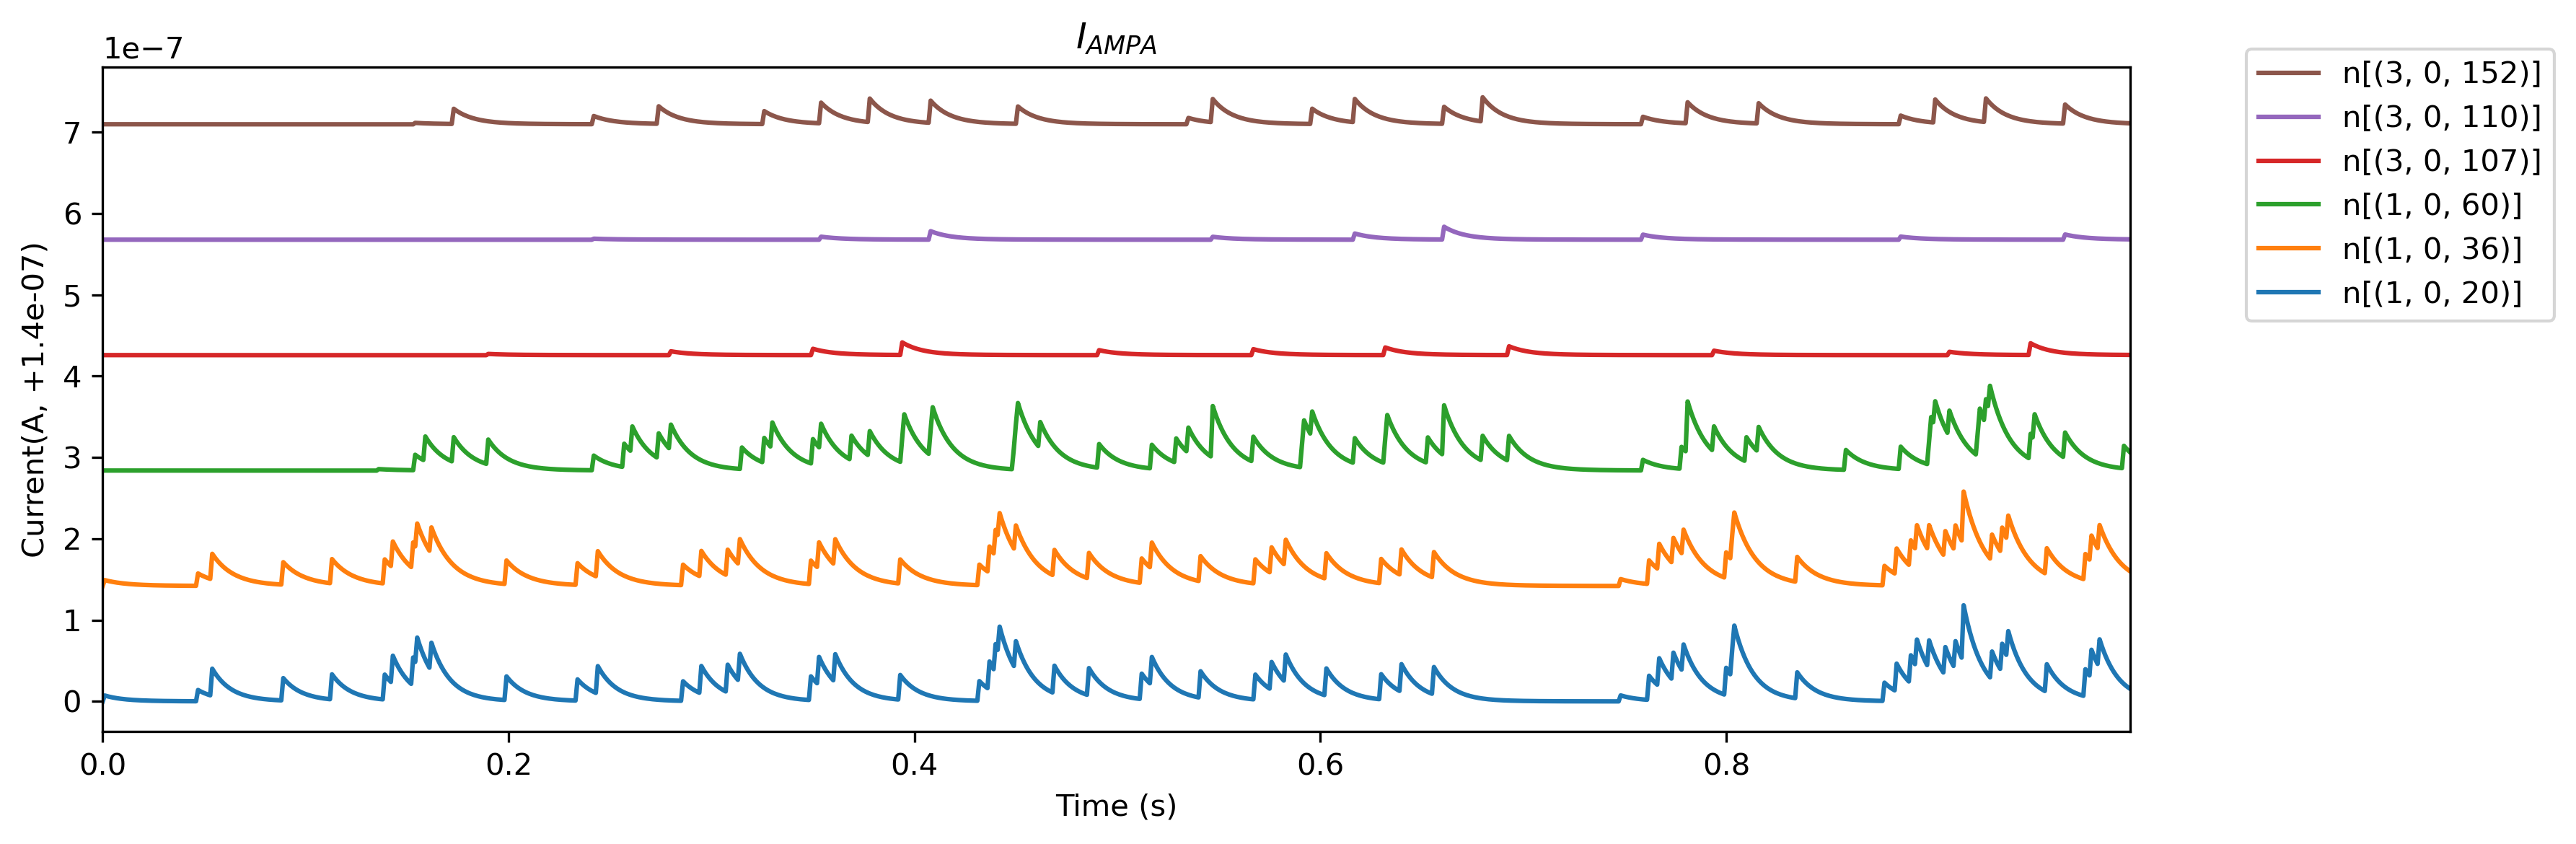

In [20]:
for c in se1.syn_types:
    plt.figure()
    Figure.plot_Ix(rd[f"I{c.lower()}"], name=f"$I_{{{c}}}$", idx_map=se1.idx_map);

WARNING    /home/ugurc/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/timeseries.py:2240: UserWarning:Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
 [py.warnings]



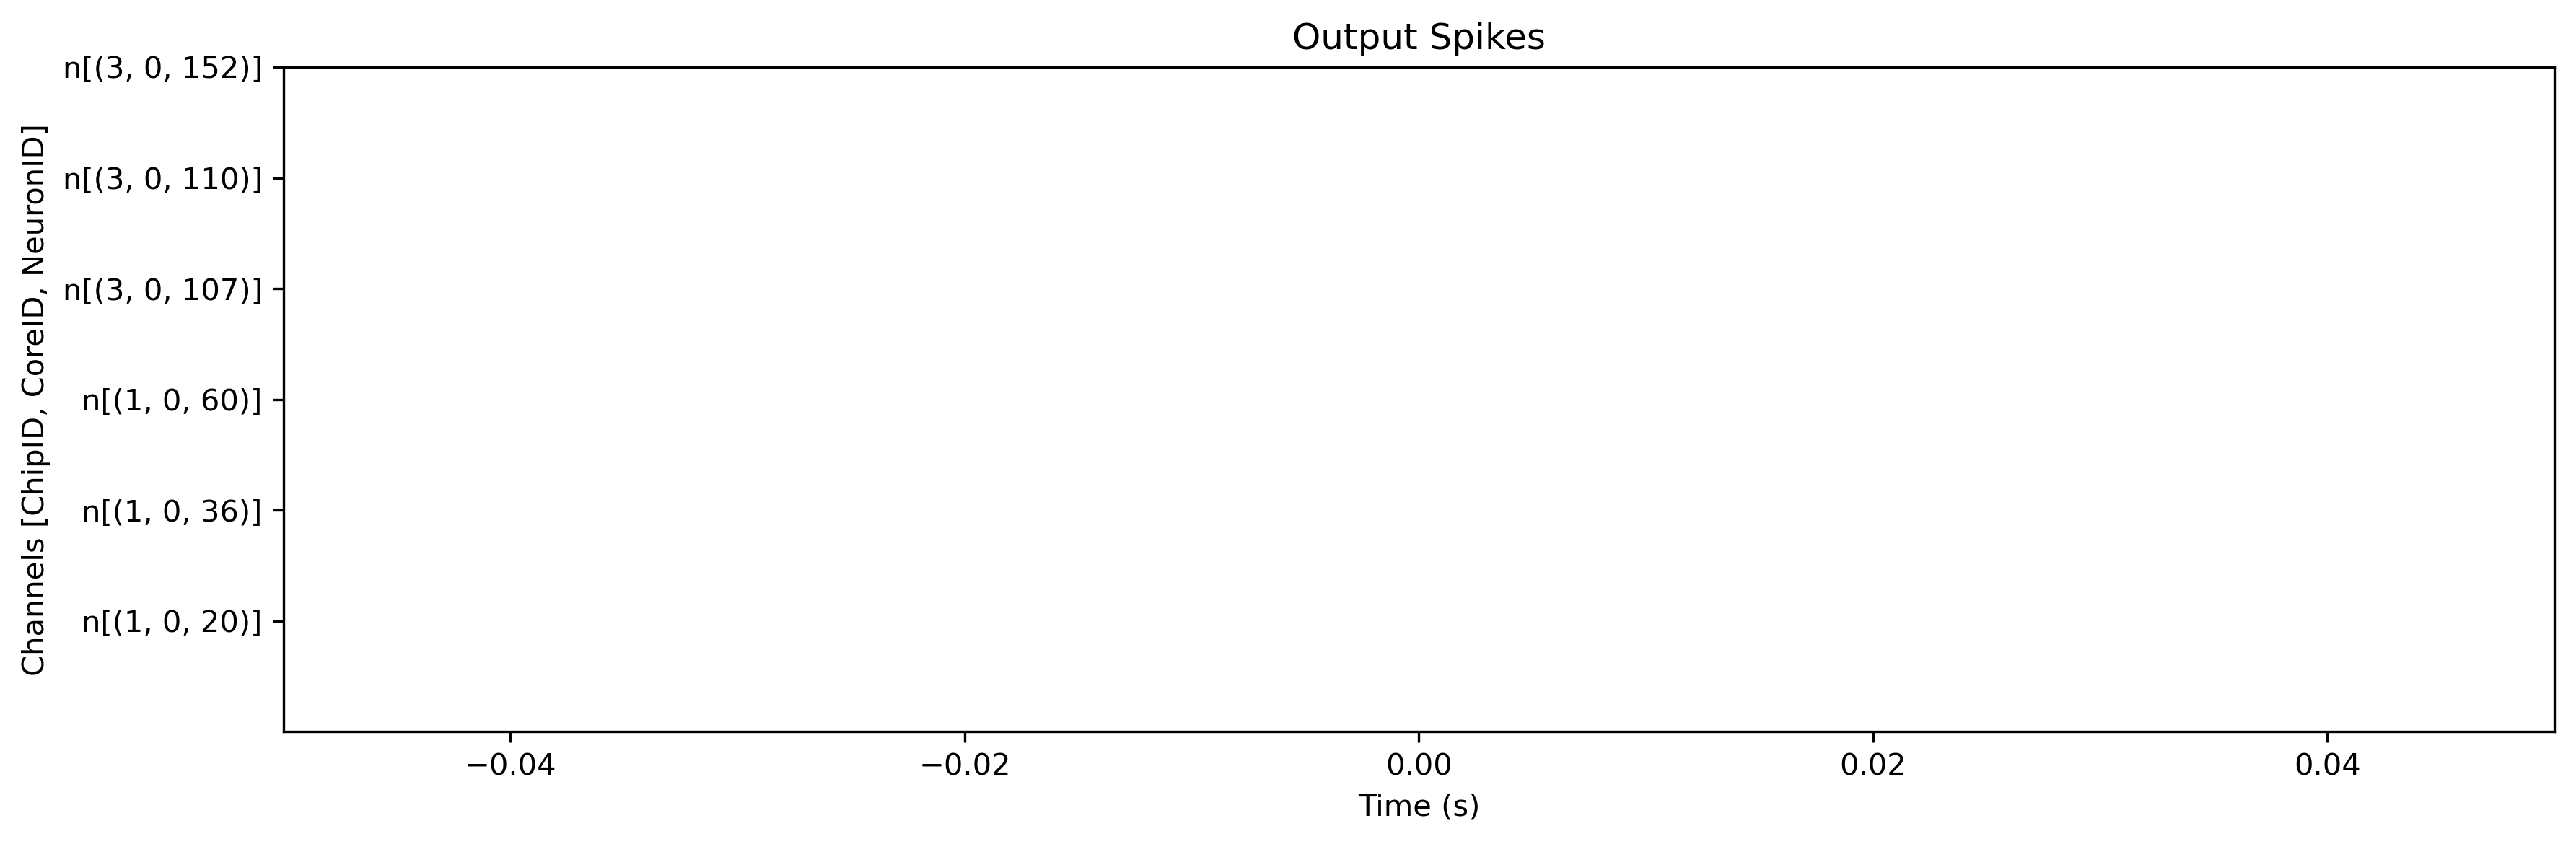

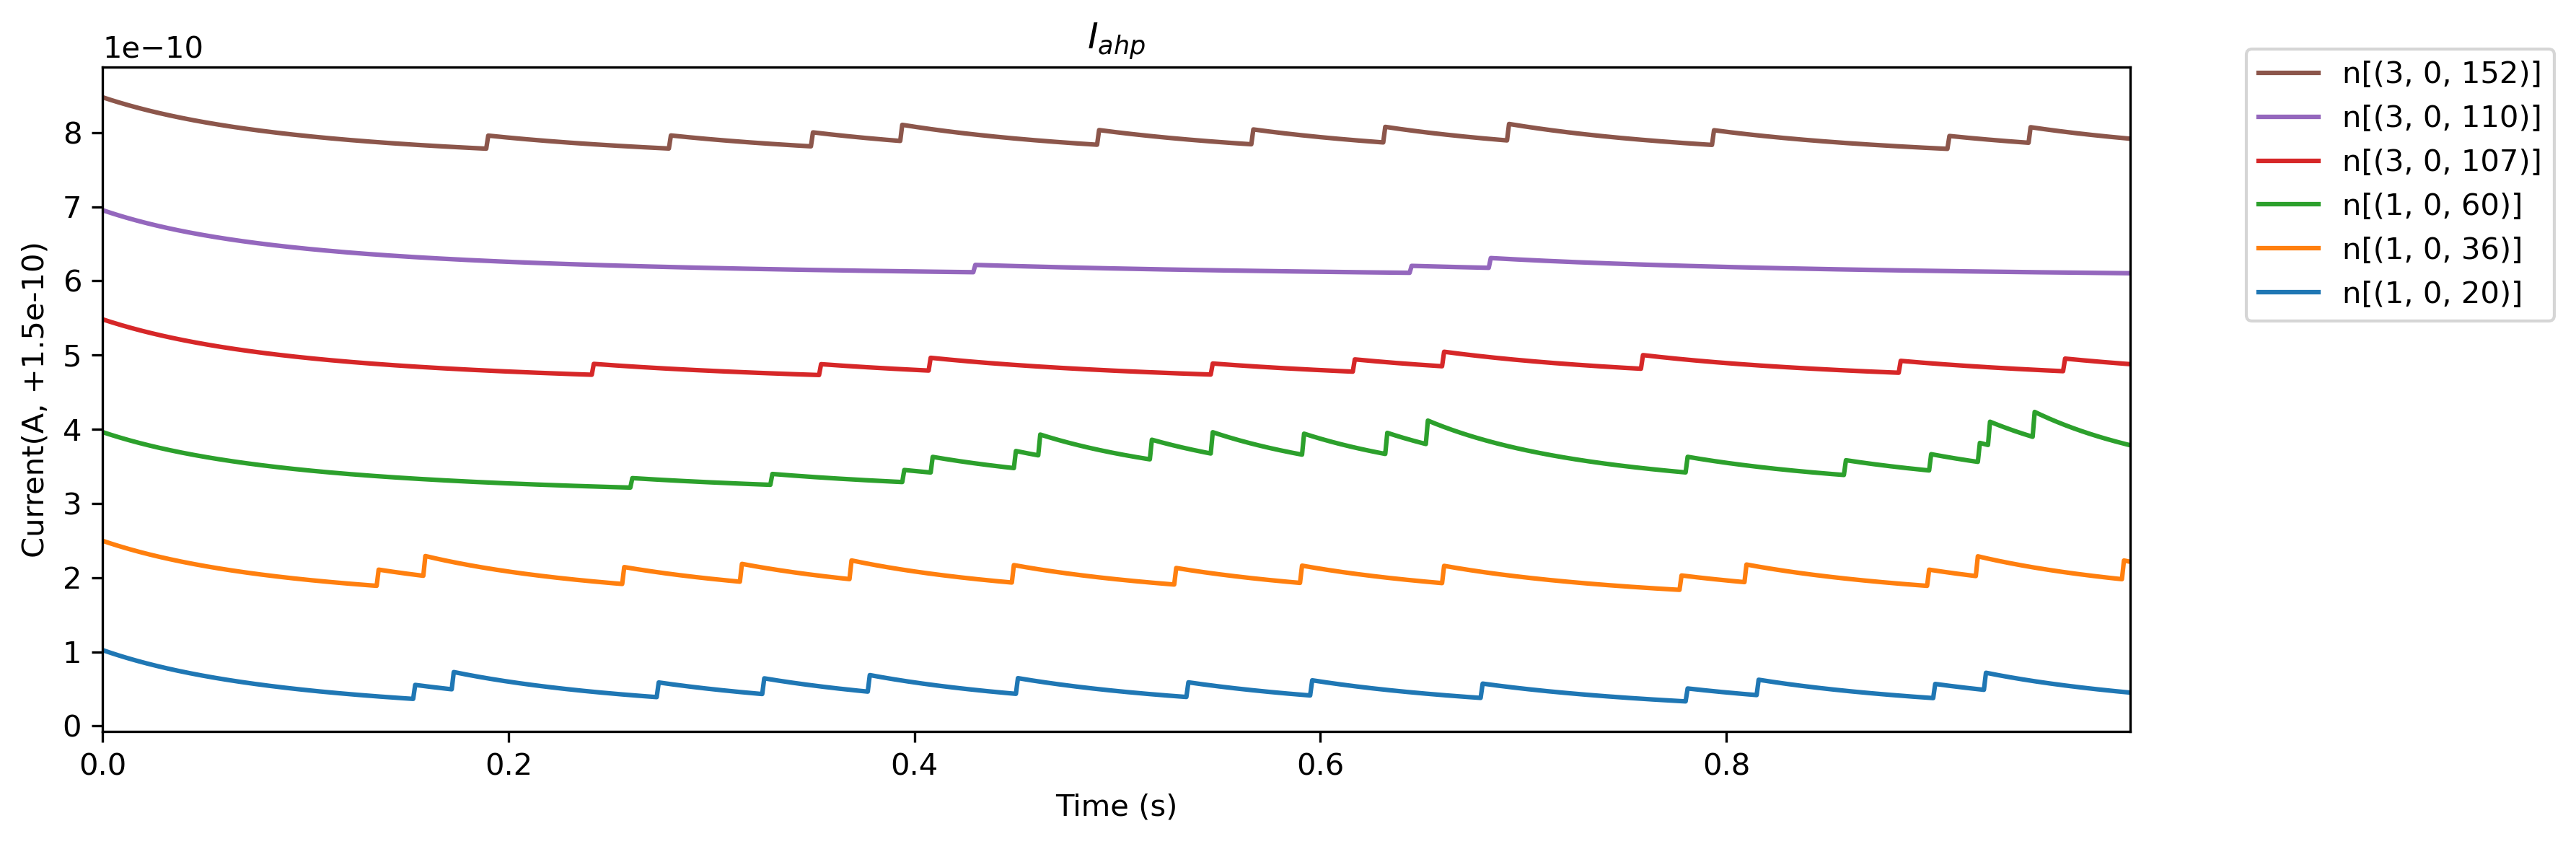

In [21]:
plt.figure()
Figure.plot_spikes(record_dict["1_DynapSE1Jax_output"], name="Output Spikes", idx_map=se1.idx_map);
plt.figure()
Figure.plot_Ix(rd[f"Iahp"], name=f"$I_{{ahp}}$", idx_map=se1.idx_map);

In [22]:
se1.idx_map

{0: (1, 0, 20),
 1: (1, 0, 36),
 2: (1, 0, 60),
 3: (3, 0, 107),
 4: (3, 0, 110),
 5: (3, 0, 152)}

In [23]:
fpga.idx_map

{0: (0, 0, 50), 1: (0, 0, 59), 2: (0, 0, 78)}

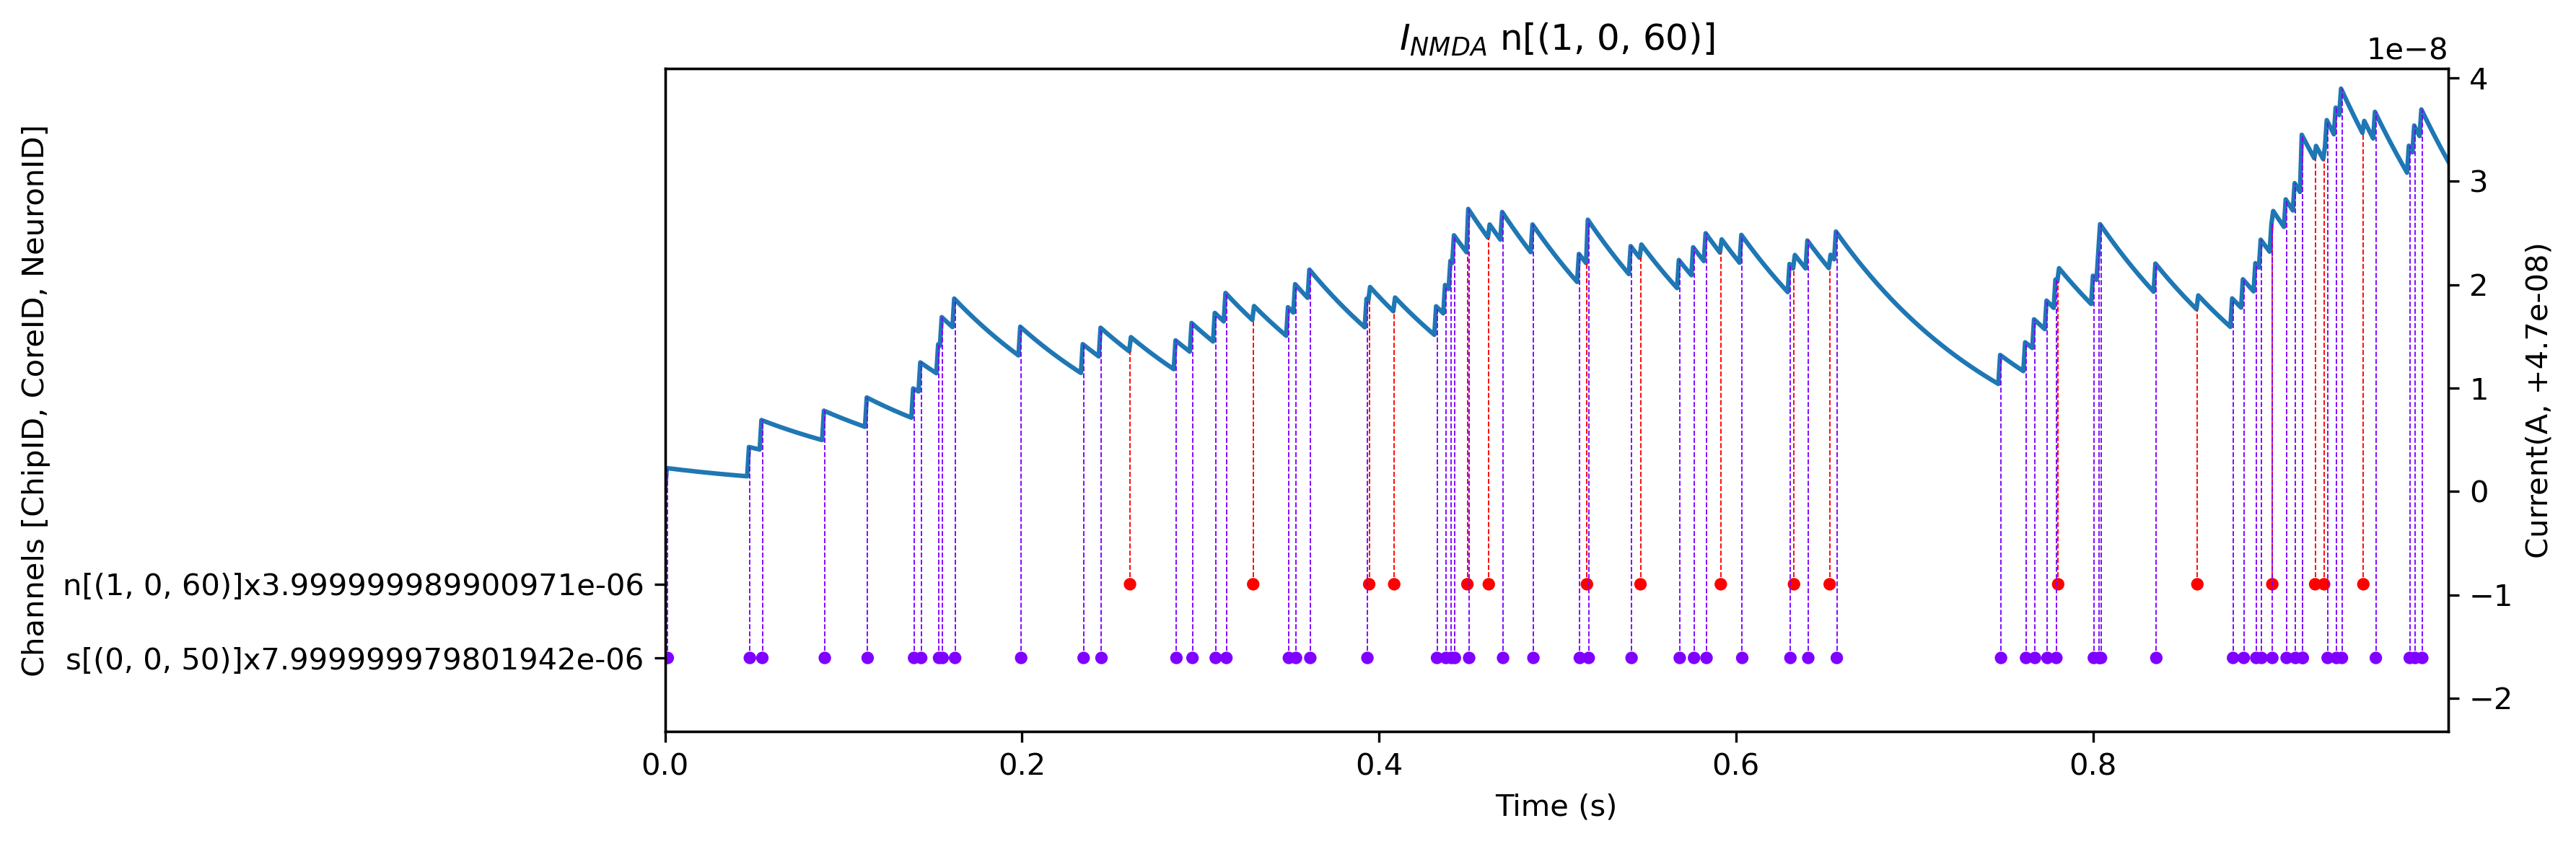

In [24]:
Figure.plot_Isyn_trace(se1, input_ts, out_spikes, rd, (1, 0, 60), "nmda", fpga);

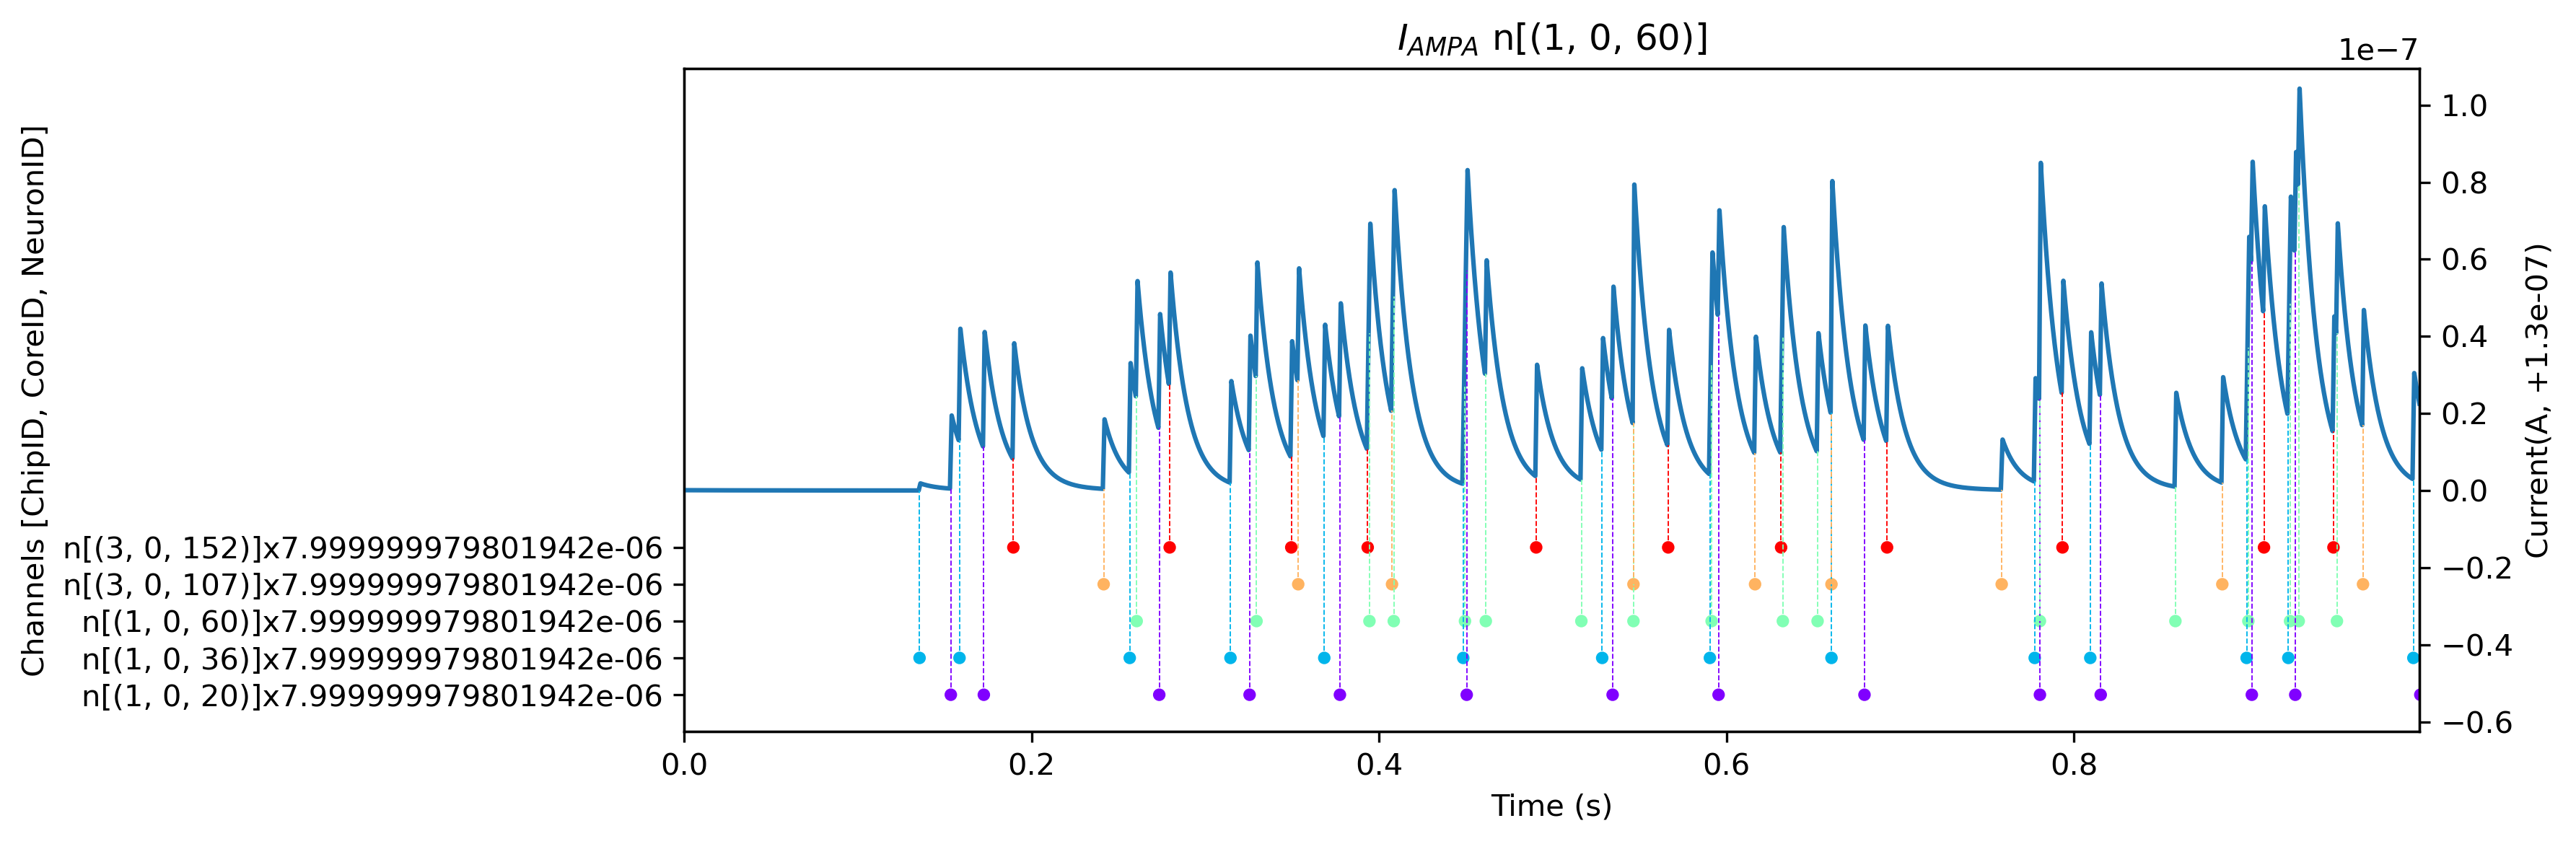

In [25]:
Figure.plot_Isyn_trace(se1, input_ts, out_spikes, rd, (1, 0, 60), "ampa", fpga);

In [26]:
se1.Ith_syn

DeviceArray([[3.5460992e-11, 3.4751774e-10, 3.5460992e-11, 3.4751774e-10],
             [3.5460992e-11, 3.4751774e-10, 3.5460992e-11, 3.4751774e-10],
             [3.5460992e-11, 3.4751774e-10, 3.5460992e-11, 3.4751774e-10],
             [3.5460992e-11, 3.4751774e-10, 3.5460992e-11, 3.4751774e-10],
             [3.5460992e-11, 3.4751774e-10, 3.5460992e-11, 3.4751774e-10],
             [3.5460992e-11, 3.4751774e-10, 3.5460992e-11, 3.4751774e-10]],            dtype=float32)

In [27]:
se1.w_rec

DeviceArray([[[0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 8.e-06],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 8.e-06]],

             [[0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 8.e-06],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00]],

             [[0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 4.e-06, 8.e-06],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00]],

             [[0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e+00, 0.e+00],
              [0.e+00, 0.e+00, 0.e

In [28]:
# se1.param_eff("w_rec")

In [29]:
# se1.md.param("Iahp")
dir(se1.md)

['Iahp',
 'Idc',
 'If_nmda',
 'Imem',
 'Io',
 'Ipulse',
 'Iref',
 'Ireset',
 'Ispkthr',
 'Isyn',
 'Itau2_mem',
 'Itau_ahp',
 'Itau_mem',
 'Itau_syn',
 'Iw_0',
 'Iw_1',
 'Iw_2',
 'Iw_3',
 'Iw_ahp',
 'Ut',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_attr_list',
 'f_gain_ahp',
 'f_gain_mem',
 'f_gain_syn',
 'f_pulse',
 'f_pulse_ahp',
 'f_ref',
 'f_tau_ahp',
 'f_tau_mem',
 'f_tau_syn',
 'kappa',
 'mismatch_ratio',
 'mm_Iahp',
 'mm_Idc',
 'mm_If_nmda',
 'mm_Imem',
 'mm_Io',
 'mm_Ipulse',
 'mm_Iref',
 'mm_Ireset',
 'mm_Ispkthr',
 'mm_Isyn',
 'mm_Itau2_mem',
 'mm_Itau_ahp',
 'mm_Itau_mem',
 'mm_Itau_syn',
 'mm_Iw_0',
 'mm_Iw_1',
 'mm_Iw_2',
 'mm_Iw_3',

In [30]:
se1.md.Iahp

DeviceArray([1.03281265e-10, 1.01142796e-10, 9.82231033e-11,
             1.00803470e-10, 9.85141690e-11, 1.01243257e-10],            dtype=float32)

In [31]:
se1.Iahp

DeviceArray([1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10], dtype=float32)

In [32]:
se1.md.param("Iahp")

DeviceArray([1.0000001e-10, 9.9999994e-11, 1.0000000e-10, 1.0000000e-10,
             1.0000000e-10, 1.0000000e-10], dtype=float32)

In [33]:
se1.md.f_gain_mem

DeviceArray([1.8681855, 2.041749 , 2.023397 , 1.9877278, 2.0365925,
             1.9873252], dtype=float32)

In [34]:
se1.f_gain_mem

DeviceArray([2., 2., 2., 2., 2., 2.], dtype=float32)